<a href="https://colab.research.google.com/github/tanaymukherjee/Time-Series-Modeling/blob/master/8_The_ARCH_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis

### Definition:
A sequence of information which attaches a time period to each value.

### Common Objective:
1. Determining the stability of financial markets and the efficiency portfolios.
2. Weather forcasting based on past records.

#### Import Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

#### Mounting Google colab with personal GDrive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Checking the content in my GDrive witihin the working directory

In [ ]:
!ls -ahl "/content/gdrive/My Drive/Colab Notebooks/Data"

#### Read the dataset

In [4]:
data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Data/Index2018.csv")

#### View the dataset summary

Date column includes the timen period where as the other features tell us the stability of market.

1. SPX is US stock exchange by S&P 500
2. DAX is German stock exchange by  DAX 30
3. FTSE is UK stock exchange by FTSE 100
4. NIKKEI is Japan stock exchange by NIKKEI 225

#### Importing the Data and Pre-processing

In [6]:
raw_csv_data = data
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [7]:
df_comp['market_value']=df_comp.ftse

In [8]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [9]:
import warnings
warnings.filterwarnings("ignore")

#### The LLR test

In [59]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit(start_ar_lags = 11).llf
    L2 = mod_2.fit(start_ar_lags = 11).llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

### Creating Returns

In [10]:
df['returns'] = df.market_value.pct_change(1)*100

### Creating Squared Returns

In [11]:
df['sq_returns'] = df.returns.mul(df.returns)

### Returns vs Squared Returns

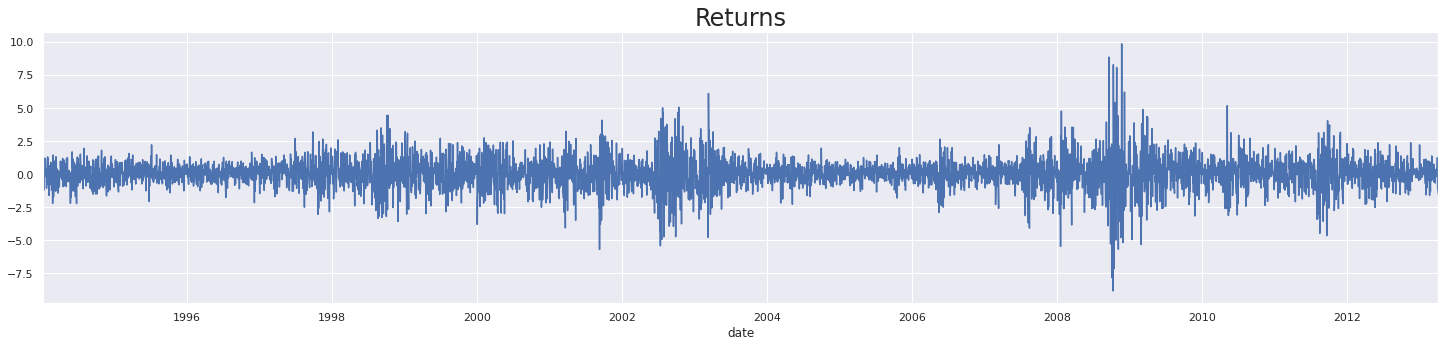

In [12]:
df.returns.plot(figsize=(25,5))
plt.title("Returns", size = 24)
plt.show()

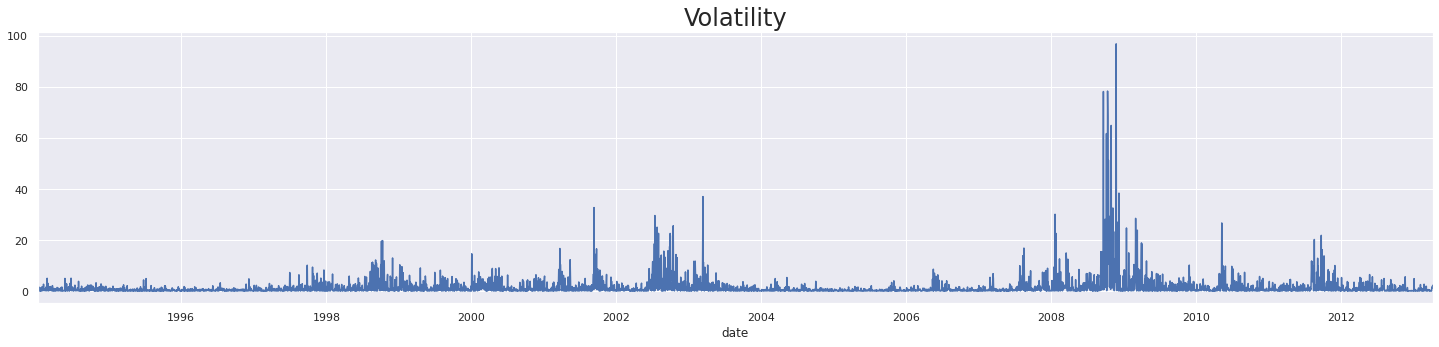

In [14]:
df.sq_returns.plot(figsize=(25,5))
plt.title("Volatility", size = 24)
plt.show()

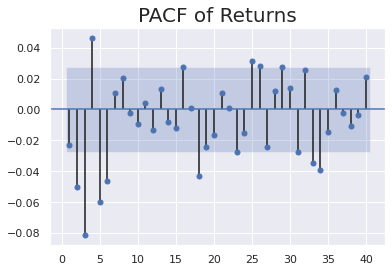

In [15]:
sgt.plot_pacf(df.returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Returns", size = 20)
plt.show()

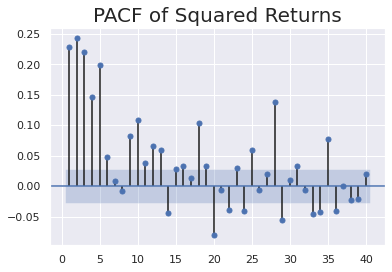

In [16]:
sgt.plot_pacf(df.sq_returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Squared Returns", size = 20)
plt.show()

### The arch_model() Method

In [22]:
!pip install arch
from arch import arch_model

     |████████████████████████████████| 808kB 4.2MB/s 


In [23]:
model_arch_1 = arch_model(df.returns[1:])
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     39,   Neg. LLF: 6972.734736835859
Iteration:     10,   Func. Count:     73,   Neg. LLF: 6970.088042271316
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6970.058366189893
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Thu, Jun 18 2020   Df Residuals:                     5016
Time:                        02:48:39   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

### The Simple ARCH(1)

In [24]:
model_arch_1 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 1)
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     34,   Neg. LLF: 7660.088789377838
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7660.088782040875
            Iterations: 6
            Function evaluations: 39
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:               -7660.09
Distribution:                  Normal   AIC:                           15326.2
Method:            Maximum Likelihood   BIC:                           15345.7
                                        No. Observations:                 5020
Date:                Thu, Jun 18 2020   Df Residuals:                     5017
Time:                        02:49:02   Df Model:                            3
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0345  1.603e-02      2.151  3.147e-02 [3.063e-03,6.590e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9206  4.309e-02     21.365 2.855e-101 [  0.836,  1.005]
alpha[1]       0.3684  5.040e-02      7.310  2.673e-13 [  0.270,  0.467]
========================================================================

Covariance estimator: robust
"""

In [25]:
model_arch_1 = arch_model(df.returns[1:], mean = "AR", lags = [2, 3, 6], vol = "ARCH", p = 1, dist = "ged")
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     56,   Neg. LLF: 7392.978753452066
Iteration:     10,   Func. Count:    109,   Neg. LLF: 7320.74917620397
Iteration:     15,   Func. Count:    156,   Neg. LLF: 7317.119673966012
Iteration:     20,   Func. Count:    205,   Neg. LLF: 7317.118107649978
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7317.118092665535
            Iterations: 22
            Function evaluations: 228
            Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - ARCH Model Results                                  
==========================================================================================
Dep. Variable:                            returns   R-squared:                       0.008
Mean Model:                                    AR   Adj. R-squared:                  0.007
Vol Model:                                   ARCH   Log-Likelihood:               -7317.12
Distribution:      Generalized Error Distribution   AIC:                           14648.2
Method:                        Maximum Likelihood   BIC:                           14693.9
                                                    No. Observations:                 5014
Date:                            Thu, Jun 18 2020   Df Residuals:                     5007
Time:                                    02:49:11   Df Model:                            7
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0474  6.131e-03      7.732  1.058e-14   [3.539e-02,5.943e-02]
returns[2]    -0.0396  2.806e-02     -1.410      0.159  [-9.457e-02,1.543e-02]
returns[3]    -0.0348  5.936e-03     -5.858  4.677e-09 [-4.641e-02,-2.314e-02]
returns[6]    -0.0283  1.728e-03    -16.391  2.235e-60 [-3.170e-02,-2.493e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9166  3.760e-02     24.378 2.951e-131 [  0.843,  0.990]
alpha[1]       0.3428  3.939e-02      8.703  3.228e-18 [  0.266,  0.420]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0675  3.251e-02     32.842 1.485e-236 [  1.004,  1.131]
========================================================================

Covariance estimator: robust
"""

In [ ]:
### Higher-Lag ARCH Models

In [26]:
model_arch_2 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 2)
results_arch_2 = model_arch_2.fit(update_freq = 5)
results_arch_2.summary()

Iteration:      5,   Func. Count:     41,   Neg. LLF: 7449.870533644225
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7449.545164098316
            Iterations: 9
            Function evaluations: 67
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:               -7449.55
Distribution:                  Normal   AIC:                           14907.1
Method:            Maximum Likelihood   BIC:                           14933.2
                                        No. Observations:                 5020
Date:                Thu, Jun 18 2020   Df Residuals:                     5016
Time:                        02:49:41   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0484  1.401e-02      3.455  5.495e-04 [2.095e-02,7.585e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6978  3.564e-02     19.580  2.272e-85 [  0.628,  0.768]
alpha[1]       0.2202  3.474e-02      6.339  2.311e-10 [  0.152,  0.288]
alpha[2]       0.2783  3.645e-02      7.635  2.260e-14 [  0.207,  0.350]
========================================================================

Covariance estimator: robust
"""

In [27]:
model_arch_3 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 3)
results_arch_3 = model_arch_3.fit(update_freq = 5)
results_arch_3.summary()

Iteration:      5,   Func. Count:     45,   Neg. LLF: 7278.805807411393
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7277.050453152619
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7277.050452148393
            Iterations: 11
            Function evaluations: 91
            Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:               -7277.05
Distribution:                  Normal   AIC:                           14564.1
Method:            Maximum Likelihood   BIC:                           14596.7
                                        No. Observations:                 5020
Date:                Thu, Jun 18 2020   Df Residuals:                     5015
Time:                        02:49:49   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0529  1.316e-02      4.018  5.875e-05 [2.707e-02,7.865e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.5012  2.834e-02     17.685  5.505e-70 [  0.446,  0.557]
alpha[1]       0.1570  2.649e-02      5.926  3.108e-09 [  0.105,  0.209]
alpha[2]       0.2197  2.588e-02      8.489  2.077e-17 [  0.169,  0.270]
alpha[3]       0.2804  3.354e-02      8.359  6.302e-17 [  0.215,  0.346]
========================================================================

Covariance estimator: robust
"""

In [28]:
model_arch_13 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 13)
results_arch_13 = model_arch_13.fit(update_freq = 5)
results_arch_13.summary()

Iteration:      5,   Func. Count:     93,   Neg. LLF: 6996.500043707073
Iteration:     10,   Func. Count:    188,   Neg. LLF: 6985.661375673177
Iteration:     15,   Func. Count:    283,   Neg. LLF: 6984.395178347233
Iteration:     20,   Func. Count:    378,   Neg. LLF: 6984.218261212904
Iteration:     25,   Func. Count:    468,   Neg. LLF: 6984.175140343418
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6984.175062618146
            Iterations: 27
            Function evaluations: 502
            Gradient evaluations: 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:               -6984.18
Distribution:                  Normal   AIC:                           13998.4
Method:            Maximum Likelihood   BIC:                           14096.2
                                        No. Observations:                 5020
Date:                Thu, Jun 18 2020   Df Residuals:                     5005
Time:                        02:49:57   Df Model:                           15
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0492  1.206e-02      4.077  4.566e-05 [2.553e-02,7.281e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1871  2.210e-02      8.466  2.538e-17      [  0.144,  0.230]
alpha[1]       0.0568  1.729e-02      3.282  1.029e-03  [2.287e-02,9.065e-02]
alpha[2]       0.1156  2.017e-02      5.733  9.840e-09    [7.610e-02,  0.155]
alpha[3]       0.1265  2.625e-02      4.820  1.433e-06    [7.509e-02,  0.178]
alpha[4]       0.0884  2.159e-02      4.093  4.265e-05    [4.605e-02,  0.131]
alpha[5]       0.0695  1.750e-02      3.970  7.189e-05    [3.518e-02,  0.104]
alpha[6]       0.0865  1.926e-02      4.491  7.092e-06    [4.874e-02,  0.124]
alpha[7]       0.0404  1.846e-02      2.188  2.870e-02  [4.203e-03,7.658e-02]
alpha[8]       0.0654  1.833e-02      3.565  3.633e-04    [2.943e-02,  0.101]
alpha[9]       0.0292  1.603e-02      1.820  6.877e-02 [-2.245e-03,6.058e-02]
alpha[10]      0.0335  1.605e-02      2.089  3.670e-02  [2.072e-03,6.498e-02]
alpha[11]      0.0775  1.760e-02      4.403  1.067e-05    [4.300e-02,  0.112]
alpha[12]      0.0473  1.873e-02      2.526  1.153e-02  [1.060e-02,8.402e-02]
alpha[13]      0.0372  1.431e-02      2.600  9.317e-03  [9.162e-03,6.526e-02]
=============================================================================

Covariance estimator: robust
"""